In this project, I read the following articles: <br>
https://www.kaggle.com/nilanml/imdb-review-deep-model-94-89-accuracy<br>
https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc<br>
https://www.kaggle.com/xchmiao/popcorn-rnn-model

# Load packages and data

In [1]:
from importlib import reload
import sys
from imp import reload
import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")
import pandas as pd
import numpy as np
from subprocess import check_output
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D, TimeDistributed, Conv1D, MaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
df1 = pd.read_csv('/Users/rileychiu/Desktop/Kaggle/Bag of Words Meets Bags of Popcorn/labeledTrainData.tsv', delimiter="\t")
df1 = df1.drop(['id'], axis=1)
df1.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


ALso import this imdb_master file.

In [3]:
df2 = pd.read_csv('/Users/rileychiu/Desktop/Kaggle/Bag of Words Meets Bags of Popcorn/imdb_master.csv',encoding="latin-1")
df2.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [4]:
df2 = df2.drop(['Unnamed: 0','type','file'],axis=1)
df2.columns = ["review","sentiment"]
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [5]:
df2 = df2[df2.sentiment != 'unsup']
df2['sentiment'] = df2['sentiment'].map({'pos': 1, 'neg': 0})
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [6]:
df = pd.concat([df1, df2]).reset_index(drop=True)
df.head()

,review,sentiment
0,With all this stuff going down at the moment w...,1
1,"\The Classic War of the Worlds\"" by Timothy Hi...",1
2,The film starts with a manager (Nicholas Bell)...,0
3,It must be assumed that those who praised this...,0
4,Superbly trashy and wondrously unpretentious 8...,1


# Data preprocessing

1. Remove non-letters <br>
2. Convert to lower case, split into individual words <br>
3. Remove stop words <br>
4. Join the words back into one string separated by space

In [7]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))

In [8]:
df.head()

,review,sentiment,Processed_Reviews
0,With all this stuff going down at the moment w...,1,stuff go moment mj ive start listen music watc...
1,"\The Classic War of the Worlds\"" by Timothy Hi...",1,classic war world timothy hines entertain film...
2,The film starts with a manager (Nicholas Bell)...,0,film start manager nicholas bell give welcome ...
3,It must be assumed that those who praised this...,0,must assume praise film greatest film opera ev...
4,Superbly trashy and wondrously unpretentious 8...,1,superbly trashy wondrously unpretentious 80 ex...


In [9]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

128.51009333333334

Tokenize reviews

In [10]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']

# Build RNN models

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
earlystop = EarlyStopping(patience=10)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

## Model1

In [15]:
embed_size = 128
model1 = Sequential()
model1.add(Embedding(max_features, embed_size))
model1.add(Bidirectional(LSTM(32, return_sequences = True)))
model1.add(GlobalMaxPool1D())
model1.add(Dense(20, activation="relu"))
model1.add(Dropout(0.05))
model1.add(Dense(1, activation="sigmoid"))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 10
model1.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks)

W0824 19:14:16.978573 140735555965824 deprecation_wrapper.py:119] From /Users/rileychiu/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 19:14:16.991790 140735555965824 deprecation_wrapper.py:119] From /Users/rileychiu/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 19:14:16.994059 140735555965824 deprecation_wrapper.py:119] From /Users/rileychiu/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 19:14:17.273484 140735555965824 deprecation_wrapper.py:119] From /Users/rileychiu/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

Train on 60000 samples, validate on 15000 samples
Epoch 1/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.3423 - acc: 0.8441 - val_loss: 0.2343 - val_acc: 0.9105
Epoch 2/10
60000/60000 [==============================] - 104s 2ms/step - loss: 0.2197 - acc: 0.9136 - val_loss: 0.2245 - val_acc: 0.9231
Epoch 3/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.1729 - acc: 0.9345 - val_loss: 0.1452 - val_acc: 0.9532
Epoch 4/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.1289 - acc: 0.9547 - val_loss: 0.0988 - val_acc: 0.9685
Epoch 5/10
60000/60000 [==============================] - 104s 2ms/step - loss: 0.0916 - acc: 0.9697 - val_loss: 0.0684 - val_acc: 0.9807
Epoch 6/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.0641 - acc: 0.9800 - val_loss: 0.1056 - val_acc: 0.9613
Epoch 7/10
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0522 - acc: 0.9827 - val_loss: 0.0476 - 

## Model2

In [16]:
embed_size = 128
model2 = Sequential()
model2.add(Embedding(max_features, embed_size))
model2.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
model2.add(Dropout(0.25))
model2.add(Dense(64))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 10
model2.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks)

Train on 60000 samples, validate on 15000 samples
Epoch 1/10
60000/60000 [==============================] - 308s 5ms/step - loss: 0.3477 - acc: 0.8486 - val_loss: 0.2651 - val_acc: 0.8902
Epoch 2/10
60000/60000 [==============================] - 292s 5ms/step - loss: 0.2393 - acc: 0.9062 - val_loss: 0.2034 - val_acc: 0.9121
Epoch 3/10
60000/60000 [==============================] - 296s 5ms/step - loss: 0.1952 - acc: 0.9247 - val_loss: 0.1455 - val_acc: 0.9508
Epoch 4/10
60000/60000 [==============================] - 299s 5ms/step - loss: 0.1559 - acc: 0.9417 - val_loss: 0.1108 - val_acc: 0.9625
Epoch 5/10
60000/60000 [==============================] - 300s 5ms/step - loss: 0.1283 - acc: 0.9534 - val_loss: 0.0973 - val_acc: 0.9659
Epoch 6/10
60000/60000 [==============================] - 296s 5ms/step - loss: 0.0972 - acc: 0.9661 - val_loss: 0.0830 - val_acc: 0.9721
Epoch 7/10
60000/60000 [==============================] - 295s 5ms/step - loss: 0.0767 - acc: 0.9735 - val_loss: 0.0945 - 

## GRU model

In [17]:
def rnn_model(use_cnn = True, use_lstm = False):
    initial_dropout = 0.2
    model=Sequential()
    model.add(Embedding(max_features, embed_size))
    model.add(Dropout(0.2))
    if use_cnn:
        model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool1D(pool_size=2))
    # Add GRU layers
    dropout_W = 0.0
    dropout_U = 0.0
    if use_lstm:
        model.add(LSTM(100, dropout = dropout_W, recurrent_dropout = dropout_U))
    else:
        model.add(GRU(100, dropout=dropout_W, recurrent_dropout=dropout_U))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [18]:
gru_model = rnn_model(use_lstm=False)
gru_model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks)

W0824 20:21:33.742436 140735555965824 deprecation_wrapper.py:119] From /Users/rileychiu/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Train on 60000 samples, validate on 15000 samples
Epoch 1/10
60000/60000 [==============================] - 55s 914us/step - loss: 0.3263 - acc: 0.8521 - val_loss: 0.2277 - val_acc: 0.9179
Epoch 2/10
60000/60000 [==============================] - 54s 902us/step - loss: 0.2036 - acc: 0.9218 - val_loss: 0.1584 - val_acc: 0.9519
Epoch 3/10
60000/60000 [==============================] - 54s 902us/step - loss: 0.1530 - acc: 0.9441 - val_loss: 0.0920 - val_acc: 0.9723
Epoch 4/10
60000/60000 [==============================] - 54s 899us/step - loss: 0.1032 - acc: 0.9648 - val_loss: 0.0612 - val_acc: 0.9809
Epoch 5/10
60000/60000 [==============================] - 54s 902us/step - loss: 0.0694 - acc: 0.9772 - val_loss: 0.0338 - val_acc: 0.9916
Epoch 6/10
60000/60000 [==============================] - 54s 902us/step - loss: 0.0461 - acc: 0.9853 - val_loss: 0.0206 - val_acc: 0.9946
Epoch 7/10
60000/60000 [==============================] - 54s 902us/step - loss: 0.0349 - acc: 0.9883 - val_loss: 0.

## LSTM model

In [19]:
lstm_model = rnn_model(use_lstm=True)
lstm_model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks)

Train on 60000 samples, validate on 15000 samples
Epoch 1/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.3263 - acc: 0.8543 - val_loss: 0.2468 - val_acc: 0.9077
Epoch 2/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.2132 - acc: 0.9177 - val_loss: 0.1786 - val_acc: 0.9379
Epoch 3/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1688 - acc: 0.9379 - val_loss: 0.1297 - val_acc: 0.9612
Epoch 4/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1233 - acc: 0.9575 - val_loss: 0.0897 - val_acc: 0.9719
Epoch 5/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0890 - acc: 0.9704 - val_loss: 0.0520 - val_acc: 0.9863
Epoch 6/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0656 - acc: 0.9792 - val_loss: 0.0378 - val_acc: 0.9890
Epoch 7/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0474 - acc: 0.9857 - val_loss: 0.0434 - val_acc

# Preprocess test set

In [20]:
test = pd.read_csv("/Users/rileychiu/Desktop/Kaggle/Bag of Words Meets Bags of Popcorn/testData.tsv", header = 0, delimiter = '\t')

In [21]:
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


Extract out the labels from the test data, due to the data leakage issue as pointed in the post<br>
https://www.kaggle.com/c/word2vec-nlp-tutorial/discussion/27022 .<br> 
The label from the test data will be used for evaluation purpose.

In [31]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
test["review"] = test.review.apply(lambda x: clean_text(x))
y_test = test["sentiment"]

In [32]:
list_sentences_test = test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

# Make prediction

In [33]:
y_test_pred_model1 = model1.predict(X_te)
y_test_pred_model1 = np.reshape(y_test_pred_model1, 25000)
y_test_pred_model1 = (y_test_pred_model1>0.5)
y_test_pred_model1 = y_test_pred_model1.astype(int)
y_test_pred_model2 = model2.predict(X_te)
y_test_pred_model2 = np.reshape(y_test_pred_model2, 25000)
y_test_pred_model2 = (y_test_pred_model2>0.5)
y_test_pred_model2 = y_test_pred_model2.astype(int)
y_test_pred_gru = gru_model.predict(X_te)
y_test_pred_gru = np.reshape(y_test_pred_gru, 25000)
y_test_pred_gru = (y_test_pred_gru>0.5)
y_test_pred_gru = y_test_pred_gru.astype(int)
y_test_pred_lstm = lstm_model.predict(X_te)
y_test_pred_lstm = np.reshape(y_test_pred_lstm, 25000)
y_test_pred_lstm = (y_test_pred_lstm>0.5)
y_test_pred_lstm = y_test_pred_lstm.astype(int)

In [34]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
print("The AUC socre for model1 is : %.4f." %roc_auc_score(y_test, y_test_pred_model1))
print("The AUC socre for model2 is : %.4f." %roc_auc_score(y_test, y_test_pred_model2))
print("The AUC socre for GRU model is : %.4f." %roc_auc_score(y_test, y_test_pred_gru))
print("The AUC socre for LSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_lstm))

The AUC socre for model1 is : 0.9954.
The AUC socre for model2 is : 0.9916.
The AUC socre for GRU model is : 0.9993.
The AUC socre for LSTM model is : 0.9960.


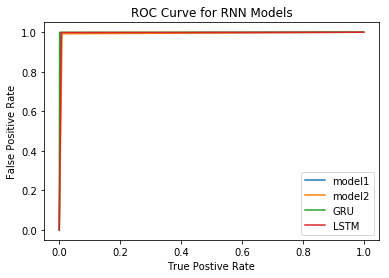

In [36]:
y_pred_list = [y_test_pred_model1, y_test_pred_model2, y_test_pred_gru, y_test_pred_lstm]
label_list = ["model1", "model2", "GRU", "LSTM"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for RNN Models")
plt.legend()
plt.show()